# Gecko dataset modelling

    
### Dataset columns descriptions

##### Original variables that were scaled:
- **id** - A unique molecule index used in naming files

- **pSat_Pa** - The saturation vapour pressure of the molecule calculated by COSMOtherm (Pa)
- **MW** - The molecular weight of the molecule (g/mol).
- **NumOfAtoms** - The number of atoms in the molecule
- **NumOfC** - The number of carbon atoms in the molecule
- **NumOfO** - The number of oxygen atoms in the molecul
- **NumOfN** - The number of nitrogen atoms in the molecule
- **NumHBondDonors** - “The number of hydrogen bond donors in the molecule, i.e. hydrogens bound to oxygen.”
- **NumOfConf** - The number of stable conformers found and successfully calculated by COSMOconf.
- **NumOfConfUsed** - The number of conformers used to calculate the thermodynamic properties.

- **cc** - The number of non-aromatic C=C bounds found in the molecule.
- **ccco** - The number of “C=C-C=O” structures found in non-aromatic rings in the molecule.
- **hydroxyl_alkl** - The number of the alkylic hydroxyl groups found in the molecule.
- **aldehyde** - The number of aldehyde groups in the molecule.
- **ketone** - The number of ketone groups in the molecule.

- **carboxylic_acid** - The number of carboxylic acid groups in the molecule.
- **ester** - The number of ester groups in the molecule.
- **ether_alicyclic** - The number of alicyclic ester groups in the molecule.
- **nitrate** - The number of alicyclic nitrate groups in the molecule
- **nitro** - The number of nitro ester groups in the molecule
- **aromatic_hydroxyl** - The number of alicyclic aromatic hydroxyl groups in the molecule.
- **carbonylperoxynitrate** - The number of carbonylperoxynitrate groups in the molecule.
- **peroxide** - The number of peroxide groups in the molecule
- **hydroperoxide** - The number of hydroperoxide groups in the molecule.
- **carbonylperoxyacid** - The number of carbonylperoxyacid groups found in the molecule
- **nitroester** - The number of nitroester groups found in the molecule
- **parentspecies** - Either “decane”, “toluene”, “apin” for alpha-pinene or a combination of these connected by an underscore to indicate ambiguous descent. In 243 cases, the parent species is “None” because it was not possible to retrieve it.
    

##### Transformed or created variables (also scaled):
                
- **trans_NumOfConf** - NumOfConf to the power of 0.3           
- **trans_MW** - Square root of trans_MW              
- **trans_pSat_Pa** - log transformed pSat_Pa                  
- **new_MW_hydroxyl_alkl_interaction** - interaction term between MW and hydroxyl_alkl
- **new_polarity_score** - polarity with assigning different weights to functional group features               
- **new_num_pca_1** - First principal component for all variable with "Num" in names               
- **new_num_pca_2** - Second principal component for all variable with "Num" in names                  

#### Variables for the one hot encoding for parentspecies:
- **ohe_parentspecies_apin** - parentspecies category apin
- **ohe_parentspecies_apin_decane** - parentspecies category decane
- **ohe_parentspecies_apin_decane_toluene** - parentspecies category apin_decane_toluene
- **ohe_parentspecies_apin_toluene** - parentspecies category apin_toluene
- **ohe_parentspecies_decane** - parentspecies category decane
- **ohe_parentspecies_decane_toluene** - parentspecies category decane_toluene

In [1]:
# Import required packages
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.decomposition import PCA, KernelPCA

data_dir = Path("data")
train_data_path = data_dir / "gecko_ml.csv"
test_data_path = data_dir / "first/gecko_ml_test.csv"

In [2]:
def prepare_data(path: Path, features: list, target: list=None):
    """Load data from the given path, select required features, preprocess the data
    and if needed select the target
    """
    dataset = pd.read_csv(path)
    if not target:
        # Test dataset lacks this column, but it is present in the training set
        dataset["ohe_parentspecies_decane_toluene"] = 0.0

    x = dataset[features]
    
    # One hot encoding of parentspecies column has Nan values, 
    # I decided to keep the rows with Nans and set each of the ohe* variables to one 
    x[x[["ohe_parentspecies_apin",
    "ohe_parentspecies_apin_decane",
    "ohe_parentspecies_apin_decane_toluene",
    "ohe_parentspecies_apin_toluene",
    "ohe_parentspecies_decane",
    "ohe_parentspecies_decane_toluene"]].isna()] = 1.0

    # id column is not a meanigful feature
    x = x.drop("id", axis=1)
    if target:
        y = dataset[target]
        return x, y
    else:
        return x
    
def transform_predictions(predictions):
    """Reverse transformation applied to the target variable. First unscales the variable based on the mean and std values from the training set
    then applies exp function. Verified to work properly on the train set."""
    df = pd.read_csv("data/train.csv")
    orig_log_mean = np.log(df["pSat_Pa"]).mean()
    orig_log_std = np.log(df["pSat_Pa"]).std()
    unscaled = unscale(predictions, orig_log_mean, orig_log_std)
    return np.exp(unscaled)

def unscale_orig_target(target):
    """Unscale the value of pSat_Pa to obtain the original values. Verified to work properly for the train set."""
    df = pd.read_csv("data/train.csv")
    orig_mean = df["pSat_Pa"].mean()
    orig_std = df["pSat_Pa"].std()
    return unscale(target, orig_mean, orig_std)

def unscale(variable, mean, std):
    return std * variable + mean

def scale(variable, mean, std):
    return (variable - mean) / std

def save_test_predictions(test_predictions, save_path, original_test_file):
    original_test = pd.read_csv(original_test_file)
    original_test["target"] = test_predictions
    original_test["Id"] = original_test["id"]
    result = original_test[["Id", "target"]]
    result.to_csv(save_path, index=False)

def cross_validate_model(model, x, y, cv=10, scoring='r2'):
    scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return scores.mean()


def find_best_feature_subset(coeff, model, x, y, start=0):
    abs_coeff = np.abs(coeff)
    search_space = np.sort(abs_coeff)[start:-1][::-1]
    search_space = search_space[search_space != 0] # don't use features with zero coefficents
    scores = []
    feats = []
    for i, val in enumerate(search_space):
        selected_feats = x.columns[abs_coeff >= val]
        if selected_feats.size == 0:
            continue
        scores.append(cross_validate_model(model, x[selected_feats], y, cv=5))
        feats.append(selected_feats.values)
        # print(f"Num features: {selected_feats.size}, current score: {scores[-1]}")
    max_score = np.max(scores)
    best_feats = feats[np.argmax(scores)]
    return best_feats, max_score, feats, scores

def validate_models(models: dict, x, y, test_name="baseline"):
    result = []
    for name, model in models.items():
        print(f"Validating model {name}")
        result.append(cross_validate_model(model, x, y))
        
    return pd.DataFrame({test_name:result}, index=models.keys())

def load_x_y(features, target="log10"):
    dependant = ['pSat_Pa', 'trans_pSat_Pa']
    x, y = prepare_data(train_data_path, features, target=dependant)
    x, y = shuffle(x, y)
    y_org = y[dependant[0]]
    y_trans = y[dependant[1]]
    y_log10 = np.log10(unscale_orig_target(y_org))
    y_log10_scaled = scale(y_log10, y_log10.mean(), y_log10.std())
    if target == "original":
        return x, y_org
    elif target == "transformed":
        return x, y_trans
    elif target == "log10":
        return x, y_log10
    elif target == "log10_scaled":
        return x, y_log10_scaled
    else:
        raise KeyError
    
def _feature_selection(coef, model, x, y, k):
    best = find_best_feature_subset(coef, model, x, y)
    best_feats, best_feats_score, feats, feats_scores = best
    if k == 1:
        return best_feats, np.std(feats_scores)
    else:
        sortedsargs = np.argsort(feats_scores)[-k:]
        return feats[sortedsargs[::-1]], feats_scores[sortedsargs[::-1]]

def linear_model_feature_selection(models, x, y, k=1):
    models["elasticnet"].fit(x, y)
    return _feature_selection(models["elasticnet"].coef_, models["lin_reg"], x, y, k)

def selectkbest_feature_selection(models, x, y, k=1):
    fs = SelectKBest(f_regression, k='all')
    fs.fit(x, y)
    return _feature_selection(fs.scores_, models["lin_reg"], x, y, k)

def save_feats(feats, filename):
    df = pd.DataFrame([], index=feats)
    df.to_csv(f"features/{filename}")

def find_best_model(models):
    features = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
        'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
        'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
        'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
        'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
        'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
        'trans_MW',
        'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
        'ohe_parentspecies_apin_decane_toluene',
        'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
        'ohe_parentspecies_decane_toluene']
    features_full = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
        'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
        'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
        'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
        'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
        'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
        'trans_MW', 'new_MW_hydroxyl_alkl_interaction',
        'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
        'ohe_parentspecies_apin_decane_toluene', 'new_polarity_score', 'new_num_pca_1', 'new_num_pca_2',
        'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
        'ohe_parentspecies_decane_toluene']
    x, y = load_x_y(features_full)

    lin_feats, lin_std = linear_model_feature_selection(models, x, y)
    skb_feats, skb_std = selectkbest_feature_selection(models, x, y)
    print(f"Lin feats:\n {lin_feats}")
    print(f"SKB feats:\n {skb_feats}")
    print(lin_std, skb_std)
    lin_x = x[lin_feats]
    skb_x = x[skb_feats]
    lin_scores = validate_models(models, lin_x, y)
    skb_scores = validate_models(models, skb_x, y)
    print(lin_scores)
    print(skb_scores)
    # save_feats(lin_feats, f"lin_svrscore_{lin_scores['svr']:0.4f}.csv" )
    # save_feats(skb_feats, f"skb_svrscore_{skb_scores['svr']:0.4f}.csv" )
    return lin_feats, skb_feats

def generate_test_preds(model, feature_dir='features', pred_dir='predictions'):
    features_full = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
        'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
        'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
        'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
        'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
        'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
        'trans_MW', 'new_MW_hydroxyl_alkl_interaction',
        'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
        'ohe_parentspecies_apin_decane_toluene', 'new_polarity_score', 'new_num_pca_1', 'new_num_pca_2',
        'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
        'ohe_parentspecies_decane_toluene']
    x, y = load_x_y(features_full)
    x_test = prepare_data(test_data_path, features_full)
    
    ft_dir = Path(feature_dir)
    for file in ft_dir.glob("*"):
        feats = pd.read_csv(file).iloc[:, 0]
        model.fit(x[feats], y)
        preds = model.predict(x_test[feats])
        save_test_predictions(preds, f"{pred_dir}/{file.name}", test_data_path)

In [3]:
df = pd.read_csv(train_data_path)
df.columns

Index(['id', 'pSat_Pa', 'MW', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
       'NumHBondDonors', 'NumOfConf', 'NumOfConfUsed', 'cc', 'ccco',
       'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
       'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
       'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
       'carbonylperoxyacid', 'nitroester', 'parentspecies', 'trans_NumOfConf',
       'trans_MW', 'trans_pSat_Pa', 'new_MW_hydroxyl_alkl_interaction',
       'new_polarity_score', 'new_num_pca_1', 'new_num_pca_2',
       'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
       'ohe_parentspecies_apin_decane_toluene',
       'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
       'ohe_parentspecies_decane_toluene', 'trans_log10_noscale_pSat_Pa'],
      dtype='object')

In [3]:
features = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
       'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
       'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
       'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
       'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
       'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
       'trans_MW',
       'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
       'ohe_parentspecies_apin_decane_toluene',
       'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
       'ohe_parentspecies_decane_toluene']
target = ['pSat_Pa', 'trans_pSat_Pa', 'trans_log10_noscale_pSat_Pa']


original_x, original_y = prepare_data(train_data_path, features, target=target)
x, y = prepare_data(train_data_path, features, target=target)
x_test = prepare_data(test_data_path, features)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5)
y_train_trans = y_train[target[2]]
y_val_trans = y_val[target[2]]

x, y = shuffle(x, y)
y_org = y[target[0]]
y_trans = y[target[2]] # This is log10 transformed by Guang


/tmp/ipykernel_34208/3333721820.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["ohe_parentspecies_apin",
/tmp/ipykernel_34208/3333721820.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["ohe_parentspecies_apin",
/tmp/ipykernel_34208/3333721820.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["oh

# Baseline models
In this section I will cross validate several models on the whole dataset and observe their performance.
I will use models:
- linear regression (also with regularization)
- random forest
- support vector regressor
- gradient boosting regressor

I selected these models, because they represent a variety of approaches used to solve regression problems, and also they are the most popular ML models.

In [4]:
# Define the models
lin_reg = LinearRegression()
rf = RandomForestRegressor()
svr = SVR()
gbr = GradientBoostingRegressor()

In [5]:
# Use cross validation to find the best Lasso and Ridge regularization parameters 
elasticnetcv = ElasticNetCV(cv=10)
elasticnetcv.fit(x.to_numpy(), y_trans.to_numpy())
print(elasticnetcv.alpha_, elasticnetcv.l1_ratio_)

0.0030023605170823035 0.5


In [5]:
# Define regularized linear regression model, with parameters influenced by the result of the previous cross validation
# I decided to only use Lasso regression, because it produced better results in my own experiments and has the advantage of producing 0 valued coefficients
elasticnet = ElasticNet(alpha=0.003, l1_ratio=1)

In [6]:
models = {}
models["lin_reg"] = lin_reg
models["rf"] = rf
models["svr"] = svr
models["gbr"] = gbr
models["elasticnet"] = elasticnet

In [8]:
baseline_scores = validate_models(models, x, y_trans)
baseline_scores

Validating model lin_reg


Validating model rf
Validating model svr
Validating model gbr
Validating model elasticnet


,baseline
lin_reg,0.709666
rf,0.714040
svr,0.747972
gbr,0.723740
elasticnet,0.707905


# Feature selection
After calculating the baseline scores, I can start feature selection. I will use several techniques to find the best features. These techniques are:
- Selecting features based on the coefficients of the regularized linear regression model.
- Using feature selection based on F-scores
- Using PCA to transform the feature space and based on that selecting the important principal components

### 1. Feature selection based on the linear regression coefficients

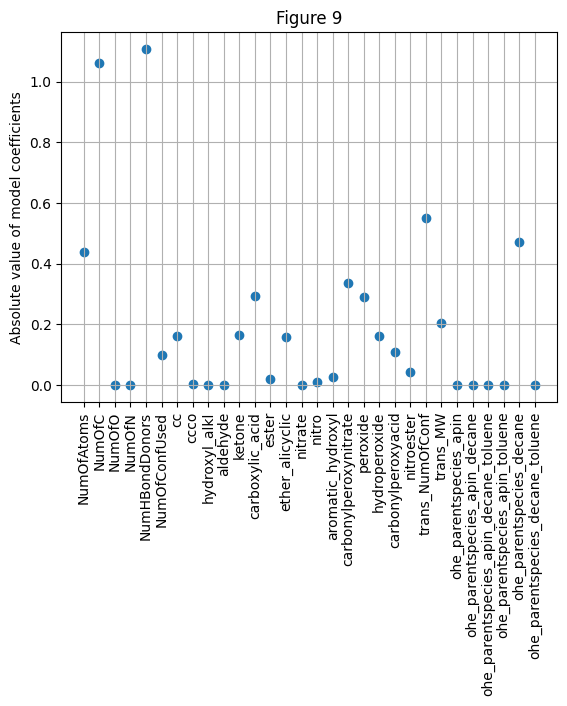

In [115]:
# New target transformation
elasticnet.fit(x, y_trans)
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(9)
plt.scatter(np.arange(elasticnet.coef_.size), np.abs(elasticnet.coef_))
plt.grid(True)
plt.ylabel("Absolute value of model coefficients")
plt.xticks(np.arange(elasticnet.coef_.size), x.columns, rotation='vertical')
plt.title("Figure 9")
plt.savefig("data/pic/figure_9.png")

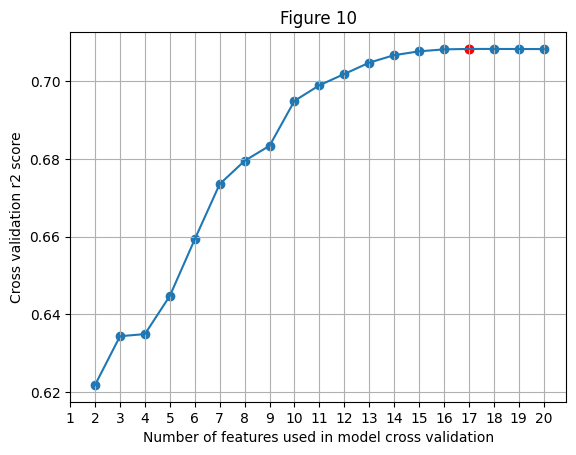

In [116]:
best_feats, best_feats_score, feats, feats_scores = find_best_feature_subset(elasticnet.coef_, lin_reg, x, y_trans)
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(9)
plt.plot([len(f) for f in feats], feats_scores)
plt.scatter([len(f) for f in feats], feats_scores)
plt.scatter(len(best_feats), best_feats_score, c='r')
plt.grid(True)
plt.xticks(np.arange(1, 21))
plt.xlabel("Number of features used in model cross validation")
plt.ylabel("Cross validation r2 score")
plt.title("Figure 10")
plt.savefig("data/pic/figure_10.png")


In [101]:
sel_feats = feats[13]
len(sel_feats)

15

### 2. Feature selection based on F-scores

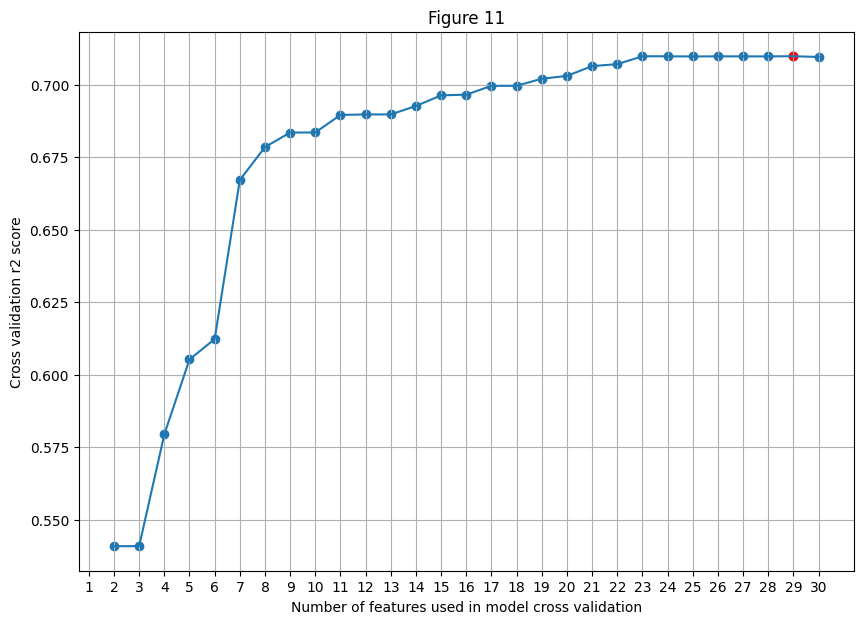

In [117]:
fs = SelectKBest(f_regression, k='all')
fs.fit(x, y_trans)
best_feats_sk, best_feats_score_sk, feats_sk, feats_scores_sk = find_best_feature_subset(fs.scores_, lin_reg, x, y_trans)
fig, ax = plt.subplots()
plt.plot([len(f) for f in feats_sk], feats_scores_sk)
plt.scatter([len(f) for f in feats_sk], feats_scores_sk)
plt.scatter(len(best_feats_sk), best_feats_score_sk, c='r')

plt.grid(True)
plt.xticks(np.arange(1, 31))

plt.xlabel("Number of features used in model cross validation")
plt.ylabel("Cross validation r2 score")
plt.title("Figure 11")
fig.set_figwidth(12)
fig.set_figheight(9)
plt.savefig("data/pic/figure_11.png")



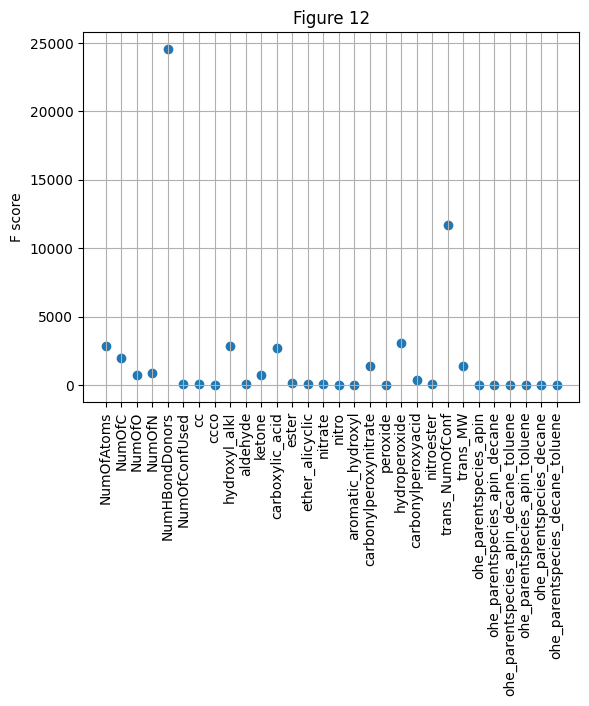

In [118]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(9)
plt.grid(True)
plt.scatter(np.arange(fs.scores_.size), fs.scores_)
plt.title("Figure 12")
plt.ylabel("F score")
plt.xticks(np.arange(fs.scores_.size), x.columns, rotation='vertical')
# ax.set_xticklabels(x.columns, rotation="")

plt.savefig("data/pic/figure_12.png")

plt.show()

In [100]:
sel_feats_sk = feats_sk[21]
len(sel_feats_sk)

23

### 3. PCA

In [13]:
pca = PCA(n_components='mle')
pca.fit(x)
print(f"The best number of principal components is: {pca.components_.shape[0]}")

The best number of principal components is: 28


In [103]:
pca = PCA(n_components=28)
pca.fit(x)

PCA(n_components=28)

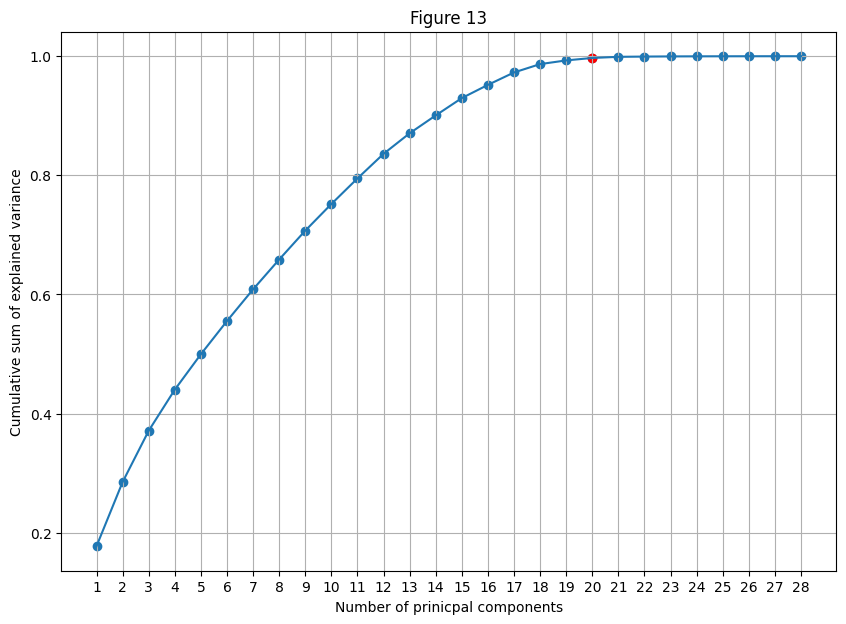

In [119]:

pca_ex_var = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
plt.plot(np.arange(1, 29), pca_ex_var)
plt.scatter(np.arange(1, 29), pca_ex_var)
plt.scatter(20, pca_ex_var[19], c='r')
plt.ylabel("Cumulative sum of explained variance")
plt.xlabel("Number of prinicpal components")
plt.xticks(np.arange(1, 29))
fig.set_figwidth(12)
fig.set_figheight(9)
plt.grid(True)
plt.title("Figure 13")
plt.savefig("data/pic/figure_13.png")

plt.show()

In [13]:
pca = PCA(n_components=20)
pca.fit(x)

PCA(n_components=20)

### 4. Model comparison based on the selected features

In [15]:

lin_feats_scores = validate_models(models, x[best_feats], y_trans, "lin reg features")
skb_feats_scores = validate_models(models, x[best_feats_sk], y_trans, "skb features")
pca_scores = validate_models(models, PCA(n_components=28).fit_transform(x), y_trans, "pca")
scores_combined = pd.concat([baseline_scores, lin_feats_scores, skb_feats_scores, pca_scores])
scores_combined

Validating model lin_reg
Validating model rf
Validating model svr
Validating model gbr
Validating model elasticnet
Validating model lin_reg
Validating model rf
Validating model svr
Validating model gbr
Validating model elasticnet
Validating model lin_reg
Validating model rf
Validating model svr
Validating model gbr
Validating model elasticnet


,baseline,lin reg features,skb features,pca
lin_reg,0.709666,NaN,NaN,NaN
rf,0.714040,NaN,NaN,NaN
svr,0.747972,NaN,NaN,NaN
gbr,0.723740,NaN,NaN,NaN
elasticnet,0.707905,NaN,NaN,NaN
lin_reg,NaN,0.708340,NaN,NaN
rf,NaN,0.704838,NaN,NaN
svr,NaN,0.741367,NaN,NaN
gbr,NaN,0.718606,NaN,NaN
elasticnet,NaN,0.708032,NaN,NaN


In [20]:
scores_combined = pd.concat([baseline_scores, lin_feats_scores, skb_feats_scores, pca_scores], axis=1)
scores_combined

,baseline,lin reg features,skb features,pca
lin_reg,0.709666,0.708340,0.709697,0.709684
rf,0.714040,0.704838,0.713530,0.710483
svr,0.747972,0.741367,0.748168,0.747972
gbr,0.723740,0.718606,0.723827,0.704239
elasticnet,0.707905,0.708032,0.707976,0.707652


In [21]:
# Save features
save_feats(best_feats, "best_linear_feats.csv")
save_feats(best_feats_sk, "best_fscore_feats.csv")


In [114]:
cross_validate_model(svr, x[sel_feats_sk], y_trans, cv=5)


0.7467575770394015

### 5. Additional features

Based on the results from above, it is clear that all of the features contribute to the result. Next step is to try creating new features in order to improve the score.

In [7]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
poly_x = poly.fit_transform(x)

In [16]:
poly_feats_scores = validate_models(models, *shuffle(poly_x, y_trans), "poly features")
poly_feats_scores

Validating model lin_reg
Validating model rf
Validating model svr
Validating model gbr
Validating model elasticnet


/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+01, tolerance: 1.155e+01
  model = cd_fast.enet_coordinate_descent(
/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e+01, tolerance: 1.161e+01
  model = cd_fast.enet_coordinate_descent(
/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

,poly features
lin_reg,-3830.940824
rf,0.715941
svr,0.737504
gbr,0.728260
elasticnet,0.742700


In [ ]:
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>poly features</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Polynomial features</th>
      <td>0.746813</td>
      <td>0.715941</td>
      <td>0.737504</td>
      <td>0.728260</td>
      <td>0.742700</td>
    </tr>
    <tr>
      <th>rf</th>
    </tr>
    <tr>
      <th>svr</th>
    </tr>
    <tr>
      <th>gbr</th>
    </tr>
    <tr>
      <th>elasticnet</th>
    </tr>
  </tbody>
</table>
</div>

In [121]:
cross_validate_model(LinearRegression(fit_intercept=False), poly_x, y_trans)

0.7468133149991373

In [126]:
cross_validate_model(ElasticNet(fit_intercept=False, alpha=0.001, l1_ratio=0.9), *shuffle(poly_x, y_trans))

/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.905e+03, tolerance: 4.780e+01
  model = cd_fast.enet_coordinate_descent(
/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.356e+03, tolerance: 4.787e+01
  model = cd_fast.enet_coordinate_descent(
/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

0.7464410760341011

In [11]:
elasticnetcv = ElasticNetCV(cv=5, l1_ratio=0.9)
elasticnetcv.fit(poly_x, y_trans)
print(elasticnetcv.alpha_, elasticnetcv.l1_ratio_)

/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.995146513312648, tolerance: 10.283882311840877
  model = cd_fast.enet_coordinate_descent_gram(
/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.510068844174384, tolerance: 10.283882311840877
  model = cd_fast.enet_coordinate_descent_gram(
/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.800683925943304, tolerance: 10.283882311840877
  model = cd_fast.enet_coordinate_descent_gram(
/home/dominik

0.0016679780650457306 0.9


/home/dominik/helsinki/IMLProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e+01, tolerance: 1.288e+01
  model = cd_fast.enet_coordinate_descent(


### 6. Best parameter selection

In [19]:
c_vals = [0.5, 1.0, 1.5, 2.0, 5.0]
scores = []
shuffled_data = shuffle(x, y_trans)
for c in c_vals:
    svr_reg = SVR(C=c)
    scores.append(cross_validate_model(svr_reg, *shuffled_data, cv=5).mean())
for c, score in zip(c_vals, scores):
    print(f"Achieved score: {score} for C: {c}")

Achieved score: 0.7417831096820852 for C: 0.5
Achieved score: 0.7461920149207237 for C: 1.0
Achieved score: 0.7478729484334259 for C: 1.5
Achieved score: 0.7487771746403811 for C: 2.0
Achieved score: 0.7485055900129048 for C: 5.0


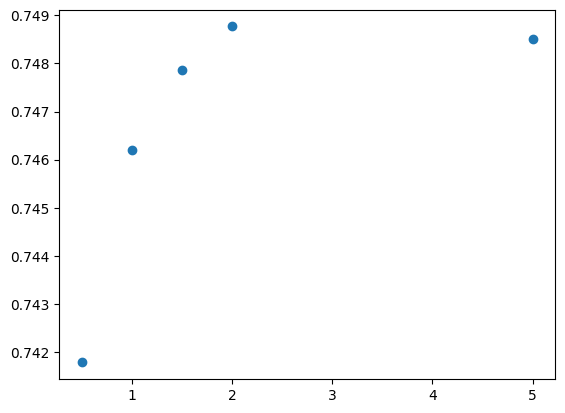

In [10]:
c_vals = [0.5, 1.0, 1.5, 2.0, 5.0]
scores = [0.74178, 0.74619, 0.74787, 0.74877, 0.74850]
plt.scatter(c_vals, scores)

### 7. Final model 

In [14]:
model = SVR(C=1.5)
model.fit(x, y_trans)
preds = model.predict(x_test)
save_test_predictions(preds, "predictions/svr_c1_5.csv", test_data_path)

In [17]:
model2 = GradientBoostingRegressor()
model2.fit(x[best_feats_sk], y_trans)
preds2 = model2.predict(x_test[best_feats_sk])
save_test_predictions(preds2, "predictions/gbr_best_fscore_feats.csv", test_data_path)

In [18]:
model3 = SVR()
model3.fit(x[best_feats_sk], y_trans)
preds3 = model3.predict(x_test[best_feats_sk])
save_test_predictions(preds3, "predictions/svr_best_fscore_feats.csv", test_data_path)

In [19]:
model4 = SVR()
model4.fit(pca.transform(x), y_trans)
preds4 = model4.predict(pca.transform(x_test))
save_test_predictions(preds4, "predictions/svr_best_pca.csv", test_data_path)

In [20]:
model5 = elasticnetcv
# model5.fit(poly_x, y_trans)
preds5 = model5.predict(poly.transform(x_test))
save_test_predictions(preds5, "predictions/en_poly_feats.csv", test_data_path)

In [ ]:
model6 = LinearRegression(fit_intercept=False)
model6.fit(poly_x, y_trans)
preds6 = model6.predict(poly.transform(x_test))
save_test_predictions(preds6, "predictions/lr_poly_feats.csv", test_data_path)

In [21]:
model7 = GradientBoostingRegressor()
model7.fit(poly_x, y_trans)
preds7 = model7.predict(poly.transform(x_test))
save_test_predictions(preds7, "predictions/gbr_poly_feats.csv", test_data_path)

/tmp/ipykernel_34208/4213113815.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data=predictions,x='preds', hue='Model', palette=['red', 'blue', 'green'])


Text(0.5, 0, 'log10(pSat_Pa)')

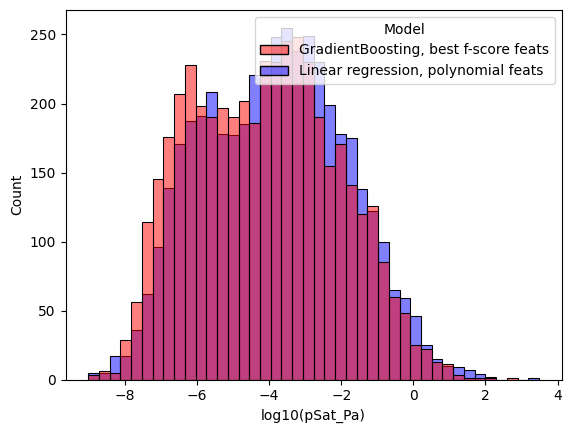

In [61]:
import seaborn as sns


full_predictions = np.concatenate([preds2,preds5])
single_labels = ["GradientBoosting, best f-score feats", "Linear regression, polynomial feats"]
labels = np.repeat(np.array(single_labels), preds.size)
# predictions
predictions = pd.DataFrame({"preds": full_predictions, "Model": labels})
# plt.legend(loc='lower left')
sns.histplot(data=predictions,x='preds', hue='Model', palette=['red', 'blue', 'green'])
# plt.legend(single_labels, bbox_to_anchor=(0.18, -0.15), loc='upper left', borderaxespad=0)
# plt.title("Histogram with models' predictions")
plt.xlabel("log10(pSat_Pa)")


In [68]:
scores = [0.69472, 0.68465,  0.69437, 0.68873, 0.69698, 0.69042]
norm_scores = (scores - np.min(scores))
norm_scores = (1/np.max(norm_scores)) * norm_scores
all_preds = [preds, preds2, preds3, preds4, preds5, preds7]
norm_scores = norm_scores / norm_scores.sum()

<Axes: ylabel='Count'>

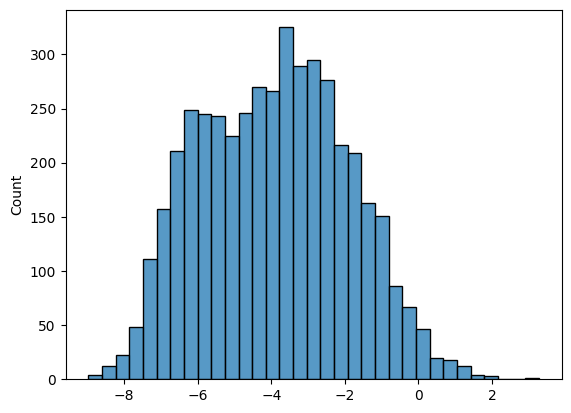

In [71]:
# Combination of the best models gives the best result

comb = (preds + preds2 + preds3 + preds4 + preds5 + preds7) / 6
sns.histplot(data=comb)

# save_test_predictions(comb, "predictions/comb6.csv", test_data_path)

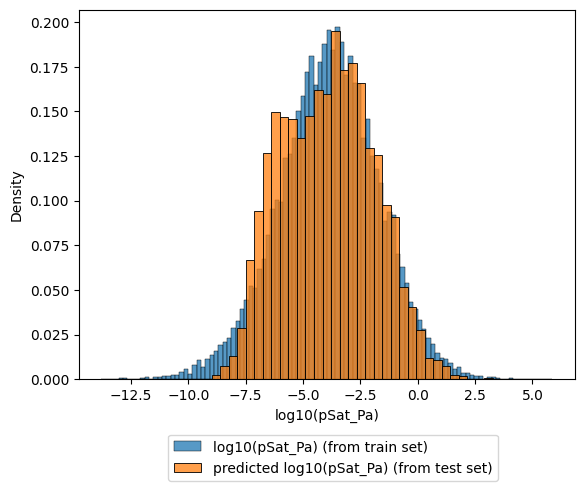

In [74]:
sns.histplot(data=y_trans, stat='density')
sns.histplot(data=comb, stat='density')
plt.xlabel("log10(pSat_Pa)")
plt.legend(["log10(pSat_Pa) (from train set)", "predicted log10(pSat_Pa) (from test set)"], bbox_to_anchor=(0.18, -0.15), loc='upper left', borderaxespad=0)


# Advanced competition

In [ ]:
# from sklearn.preprocessing import StandardScaler

# def mode_center(df, mode):
#     mode_matrix = np.ones_like(df.to_numpy()) * mode
#     mode_centered_ordinal = df.to_numpy() - mode_matrix
#     mode_centered_ordinal = pd.DataFrame(mode_centered_ordinal, columns=df.columns)
#     return mode_centered_ordinal

In [ ]:
# adv_data_dir = data_dir / "advanced"

# # Load advanced competition data
# adv_train = pd.read_csv(adv_data_dir / "train.csv")
# adv_test = pd.read_csv(adv_data_dir / "test.csv")
# adv_train_y = np.log10(adv_train["pSat_Pa"])
# adv_train_x = adv_train.drop(["pSat_Pa", "Id", "parentspecies"], axis=1)
# adv_test = adv_test.drop(["Id", "parentspecies"], axis=1)

# # Transform features MW and NumOfConf
# adv_train_x["MW"] = np.log(adv_train_x["MW"])
# adv_test["MW"] = np.log(adv_test["MW"])
# adv_train_x["NumOfConf"] = adv_train_x["NumOfConf"] ** 0.3
# adv_test["NumOfConf"] = adv_test["NumOfConf"] ** 0.3


In [ ]:

ordinal_cols = ['NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN', 'NumHBondDonors',
       'NumOfConfUsed', 'C.C..non.aromatic.', 'C.C.C.O.in.non.aromatic.ring',
       'hydroxyl..alkyl.', 'aldehyde', 'ketone', 'carboxylic.acid', 'ester',
       'ether..alicyclic.', 'nitrate', 'nitro', 'aromatic.hydroxyl',
       'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
       'carbonylperoxyacid', 'nitroester']
mode = train_x[ordinal_cols].mode().to_numpy()
train_x[ordinal_cols] = mode_center(train_x[ordinal_cols], mode)
test[ordinal_cols] = mode_center(test[ordinal_cols], mode)

scaler = StandardScaler(with_std=False)
scaler.fit(train_x[["MW", "NumOfConf"]])
train_x[["MW", "NumOfConf"]] = scaler.transform(train_x[["MW", "NumOfConf"]])
test[["MW", "NumOfConf"]] = scaler.transform(test[["MW", "NumOfConf"]])


#%%
adv = data_dir / "advanced"
embed = np.load(adv / "topFP_train.npy")
embeddf = pd.DataFrame(embed)

pca = PCA(n_components=10)
pca.fit(embeddf)

reduced_embed = pca.transform(embeddf)
reduced_embed = pd.DataFrame(reduced_embed, columns=[f"pca{i}" for i in range(1, 11)])

train_x_embed = pd.concat([train_x, reduced_embed], axis=1)
#%%
svr = SVR()

sh_x, sh_y = shuffle(train_x_embed, train_y.to_numpy().reshape((-1, 1)), random_state=1)
cross_validate_model(svr, sh_x, sh_y)

svr.fit(sh_x, sh_y)
#%%
embed = pd.DataFrame(np.load(adv / "topFP_test.npy"))

tembed = pca.transform(embed)
tembed = pd.DataFrame(tembed, columns=[f"pca{i}" for i in range(1, 11)])
test_embed = pd.concat([test, tembed], axis=1)
preds = svr.predict(test_embed)
#%%

save_test_predictions(preds, "predictions/adv_svr_pcaembed10.csv", "data/advanced/test.csv")
#%%
pca.explained_variance_ratio_
